# Testing emcee for fitting parameters

In [26]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import emcee
import corner

### Simulation Profile

In [27]:
# Select image to analyze
# i = 9, 10, 29, 30 are interesting ones
i = 91

In [28]:
img = (np.load("../profiles/dens_test.npy"))[i]
ny, nx = img.shape

# Griglia cartesiana
x = np.linspace(-3, 3, nx)
y = np.linspace(-3, 3, ny)
xx, yy = np.meshgrid(x, y)

# Griglia polare
r_i = np.linspace(0.1, 3, 300)
theta_i = np.linspace(-np.pi, np.pi, 360)
rr, tt = np.meshgrid(r_i, theta_i)

# Converti griglia polare in x, y
xi = rr * np.cos(tt)
yi = rr * np.sin(tt)

# Prendo i valori dell'immagine
points = np.vstack((xx.flatten(), yy.flatten())).T
values = img.flatten()

# Interpoloazione dell'immagin su una griglia polare
grid_intensity = griddata(points, values, (xi, yi), fill_value=0)

# Per il profilo radiale, prendo la media lungo θ
simulation_profile = np.mean(grid_intensity, axis=0)


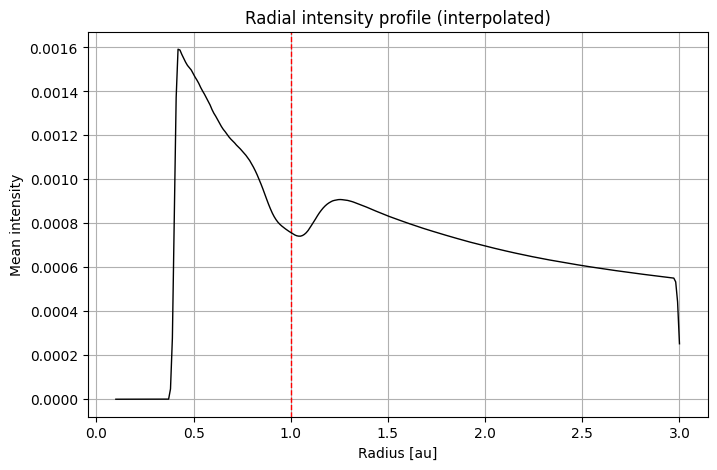

In [29]:
# Plot
plt.figure(figsize=(8, 5))
plt.axvline(1.0,
            color='red',
            linestyle='--',
            linewidth=1)
plt.plot(
    r_i,
    simulation_profile,
    color="black",
    linewidth=1,
)
plt.xlabel("Radius [au]")
plt.ylabel("Mean intensity")
plt.title("Radial intensity profile (interpolated)")
plt.grid(True)
plt.show()

### Synthetic Profile

  0%|          | 0/5000 [00:00<?, ?it/s]d:\UNI\AAAThesis\DiskGen\.venv\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:07<00:00, 662.72it/s]


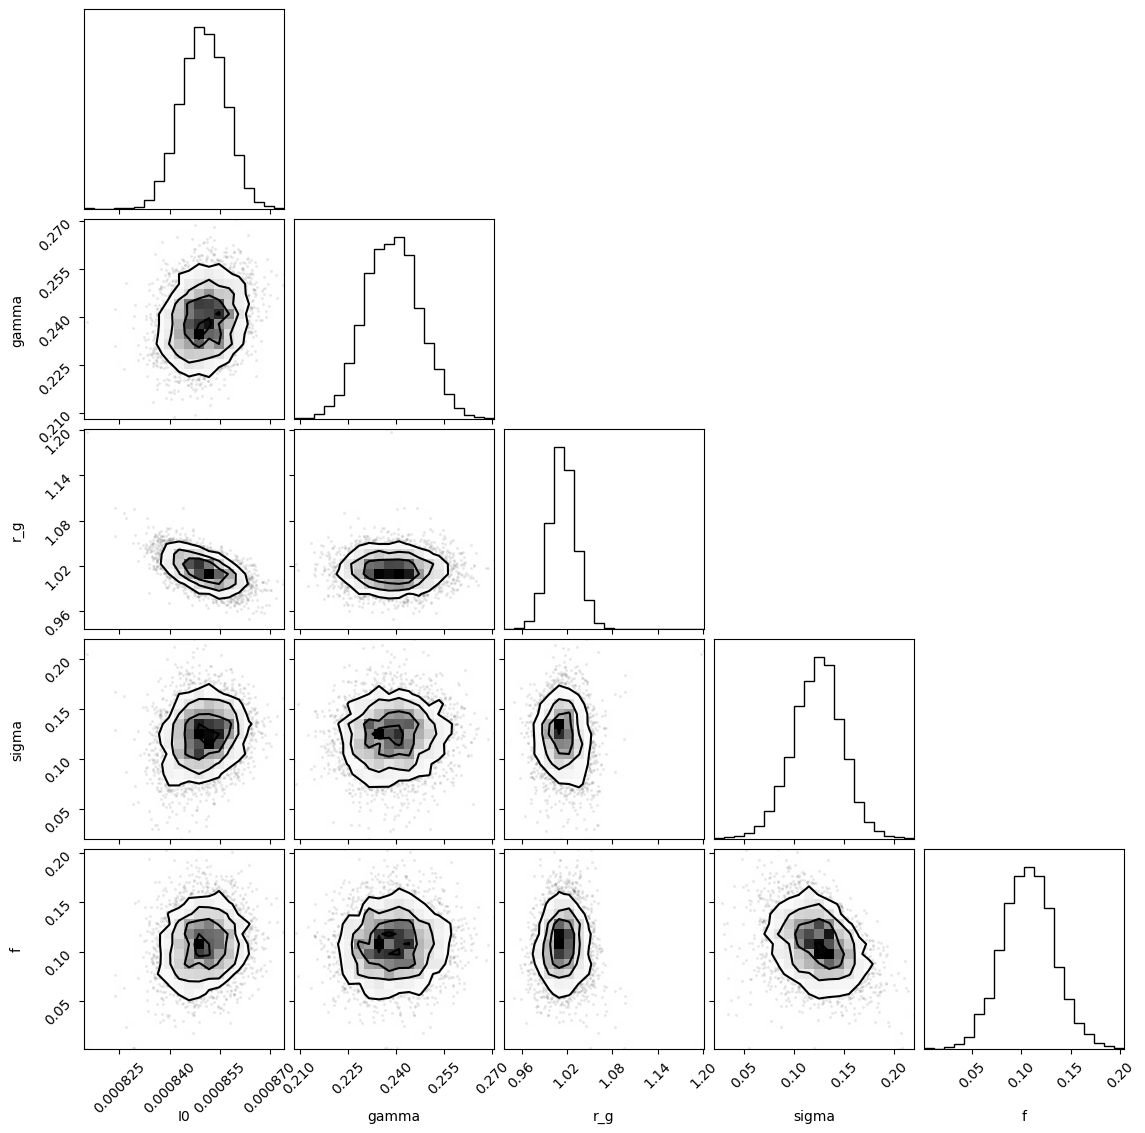

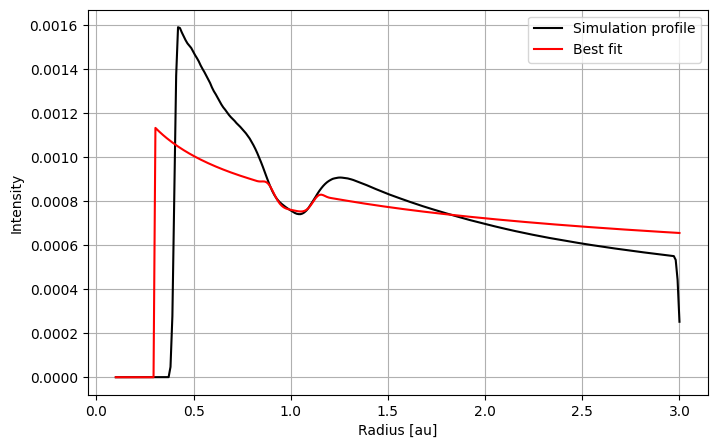

[8.50145350e-04 2.38924025e-01 1.01378202e+00 1.23933808e-01
 1.07421158e-01]


In [30]:
# Emcee
r = np.linspace(0.1, 3, 300)


def model(r, I0, gamma, r_g, sigma, f):
    c = 0.3
    R_cutL = 0.3  # Fixed
    R_cutR = 3.0  # Fixed

    r_sinc = c * (np.pi * ((r - r_g) / sigma))**2

    powerlaw = I0 * ((r / r_g)**(-gamma))
    sinc = np.sin(r_sinc) / r_sinc
    gauss = np.exp((-(r - r_g)**4) / (2 * sigma**4))
    L_cut_factor = (r >= R_cutL).astype(float)
    R_cut_factor = (r <= R_cutR).astype(float)

    gap_factor = (1 - f * (sinc * gauss))

    return powerlaw * gap_factor * L_cut_factor * R_cut_factor


def log_prior(parameters):
    I0, gamma, r_g, sigma, f = parameters
    if 0. < I0 < 1. and 0. < gamma < 1. and 0.1 < r_g < 3.0 and 0.01 < sigma < 0.5 and 0.0 < f < 1.0:
        return 0.0
    return -np.inf


def log_likelihood(parameters, r, data, error):
    model_profile = model(r, *parameters)
    return - 0.5 * np.sum(((data - model_profile) / error)**2)


def log_probability(parameters, r, data, error):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(parameters, r, data, error)


initial = np.array([1.0, 1.0, 1.0, 0.1, 0.5])
ndim = len(initial)
nwalkers = 20
initial_position = initial + 1e-3 * np.random.randn(nwalkers, ndim)

error = np.full_like(simulation_profile, 0.05 * np.max(simulation_profile))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r, simulation_profile, error))
sampler.run_mcmc(initial_position, 5000, progress=True)
flat_samples = sampler.get_chain(discard=1000, thin=20, flat=True)

corner.corner(flat_samples, labels=["I0", "gamma", "r_g", "sigma", "f"], truths=[None] * 5)
plt.show()

best_params = np.median(flat_samples, axis=0)
best_model = model(r_i, *best_params)

plt.figure(figsize=(8, 5))
plt.plot(r_i, simulation_profile, label="Simulation profile", color="black")
plt.plot(r_i, best_model, label="Best fit", color="red")
plt.xlabel("Radius [au]")
plt.ylabel("Intensity")
plt.legend()
plt.grid(True)
plt.show()

print(best_params)
